In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
def calculate_eddy(width=500000, num_depth_layers=21, eta0=1, L=1e5, H=1000, a=1, b=1, rho0=1025, 
                                            f0=None, alpha_1=0.01, alpha_2=0.01, T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None):
    """
    Calculate the 3D geostrophic velocity components U, V, density anomaly sigma, temperature, salinity, 
    and pressure fields for an ocean eddy.

    Parameters:
    - width: Horizontal extent of the grid (eddy scale) in meters.
    - num_depth_layers: Number of vertical layers (depth resolution).
    - eta0: Surface elevation perturbation.
    - L: Horizontal length scale of the eddy in meters.
    - H: Vertical depth scale of the eddy in meters.
    - a, b: Coefficients affecting density anomaly variation.
    - rho0: Reference density (kg/m^3).
    - f0: Coriolis parameter. If None, it will be calculated based on a latitude of -34 degrees.
    - alpha_1, alpha_2: Coefficients affecting eddy center shift with depth.
    - T0: Surface temperature (degrees Celsius).
    - dTdz: Temperature gradient with depth (degrees Celsius per meter).
    - dSdz: Salinity gradient with depth (psu per meter).
    - taper_depth: Tapering scale for vertical variations.

    Returns:
    - U, V: 3D matrices for the U and V (x- and y-components) velocity fields.
    - sigma: 3D matrix for the density anomaly.
    - T: 3D matrix for the temperature field.
    - S: 3D matrix for the salinity field.
    - P: 3D matrix for the pressure field.
    - x, y, z: Horizontal and vertical grid points.
    """

    # Constants
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))  # Coriolis parameter for latitude -34 degrees
    g = 9.81  # Gravitational acceleration (m/s^2)

    # Create 2D meshgrid for horizontal space (x, y) and depth (z)
    x = np.linspace(-width // 2, width // 2, 101)  # x-coordinates
    y = np.linspace(-width // 2, width // 2, 101)  # y-coordinates
    z = np.linspace(-H, 0, num_depth_layers)  # Depth levels from surface (0) to -H

    # Create 3D meshgrid
    x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')

    if taper_depth is None:
        taper_factor = np.ones_like(z_3d)
    else:
        taper_factor = np.exp(z_3d / taper_depth)

    # Define the functions f(|r - r_c(z)|) and g(z)
    def f_r_rc(r, L):
        return np.exp(-r**2 / L**2)

    # Calculate the center position as a function of depth
    x_c = alpha_1 * z_3d
    y_c = alpha_2 * z_3d

    # Calculate radial distance r - r_c(z)
    r_c = np.hypot( x_3d - x_c, y_3d - y_c )

    # Temperature field
    # T = T0 + dTdz * z_3d - 2 * f_r_rc(r_c, L) * taper_factor
    T = - 2 * f_r_rc(r_c, L) * taper_factor

    # Salinity field
    S0 = 35  # Reference surface salinity (psu)
    # S = S0 + dSdz * z_3d + 1.5 * f_r_rc(r_c, L) * taper_factor
    S = 1.5 * f_r_rc(r_c, L) * taper_factor

    # Pressure field (hydrostatic pressure)
    P = -rho0 * g * z_3d

    # Density field using a simplified equation of state
    alpha = 0.0002  # Thermal expansion coefficient (1/°C)
    beta = 0.0008  # Haline contraction coefficient (1/psu)
    sigma = rho0 * (1 - alpha * (T - T0) + beta * (S - S0)) 
    sigma -= np.mean(sigma)

    # Calculate geostrophic velocity components
    dx = x[1] - x[0]  # Grid spacing in x
    dy = y[1] - y[0]  # Grid spacing in y
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy

    U = g / f0 * d_sigma_dy * taper_factor
    V = -g / f0 * d_sigma_dx * taper_factor

    U = np.flip(U, axis=2)
    V = np.flip(V, axis=2)
    sigma = np.flip(sigma, axis=2)
    T = np.flip(T, axis=2)
    S = np.flip(S, axis=2)
    P = np.flip(P, axis=2)
    z = np.flip(z)

    return U, V, sigma, T, S, P, x, y, z


In [3]:
def calc_ow(uu, vv, dx, dy):
    WIDTH, LENGTH = uu.shape
    u_x = (uu[2:, :] - uu[:-2, :]) / (2 * dx)
    u_y = (uu[:, 2:] - uu[:, :-2]) / (2 * dy)
    v_x = (vv[2:, :] - vv[:-2, :]) / (2 * dx)
    v_y = (vv[:, 2:] - vv[:, :-2]) / (2 * dy)
    
    u_x = np.concatenate((np.zeros((1, LENGTH)), u_x, np.zeros((1, LENGTH))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH)), v_x, np.zeros((1, LENGTH))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1)), u_y, np.zeros((WIDTH, 1))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1)), v_y, np.zeros((WIDTH, 1))), axis=1)
    
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow

def calc_lnam(x, y, uu, vv, ow):
    f = -1
    
    # Initialization
    LNAM, LOW = np.full_like(uu, np.nan), np.full_like(uu, np.nan)
    b = np.ones_like(x, dtype=int) # 2b is the side length of the local box
    borders = np.max(b) + 1
    
    # Loop through domain to calculate LNAM and LOW
    for i in range(borders, len(vv[:, 0]) - borders + 1):
        for j in range(borders, len(vv[0, :]) - borders + 1):
            if not np.isnan(vv[i, j]):
                OW = ow[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                LOW[i, j] = np.nanmean(OW)
                
                xlocal = x[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                ylocal = y[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                ulocal = uu[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                vlocal = vv[i - b[i, j]:i + b[i, j] + 1, j - b[i, j] + 1]#:j + b[i, j] + 1]
                
                coordcentre = (xlocal.shape[0] - 1) // 2
                d_xcentre = (xlocal - xlocal[coordcentre, coordcentre])
                d_ycentre = (ylocal - ylocal[coordcentre, coordcentre])
                
                cross = (d_xcentre * vlocal) - (d_ycentre * ulocal)
                dot = (ulocal * d_xcentre) + (vlocal * d_ycentre)
                produit = np.sqrt(ulocal**2 + vlocal**2) * np.sqrt(d_xcentre**2 + d_ycentre**2)
                sumdp = np.sum(dot) + np.sum(produit)
                
                LNAM[i, j] = np.sum(cross) / sumdp * np.sign(f) if sumdp != 0 else 0
    
    return LNAM, LOW

# def calc_lnam(x, y, uu, vv, ow):
#     f = -1  # Coriolis parameter sign (adjust if needed)
    
#     # Initialize LNAM and LOW matrices with NaNs
#     LNAM = np.full_like(uu, np.nan)
#     LOW = np.full_like(uu, np.nan)
    
#     # Define the local box size
#     b = np.ones_like(x, dtype=int)  # Local box size (half-width)
#     borders = np.max(b) + 1  # To avoid out-of-bound errors
    
#     # Iterate through the domain
#     for i in range(borders, len(vv) - borders):
#         for j in range(borders, len(vv[0]) - borders):
#             if not np.isnan(vv[i, j]):
#                 # Define the local region
#                 i_min, i_max = i - b[i, j], i + b[i, j] + 1
#                 j_min, j_max = j - b[i, j], j + b[i, j] + 1
                
#                 OW = ow[i_min:i_max, j_min:j_max]
#                 LOW[i, j] = np.nanmean(OW)
                
#                 xlocal = x[i_min:i_max, j_min:j_max]
#                 ylocal = y[i_min:i_max, j_min:j_max]
#                 ulocal = uu[i_min:i_max, j_min:j_max]
#                 vlocal = vv[i_min:i_max, j_min:j_max]
                
#                 # Calculate distances relative to the center
#                 coordcentre_x = (xlocal.shape[0] - 1) // 2
#                 coordcentre_y = (xlocal.shape[1] - 1) // 2
                
#                 d_xcentre = xlocal - xlocal[coordcentre_x, coordcentre_y]
#                 d_ycentre = ylocal - ylocal[coordcentre_x, coordcentre_y]
                
#                 # Compute LNAM numerator and denominator
#                 cross = (d_xcentre * vlocal) - (d_ycentre * ulocal)
#                 dot = (ulocal * d_xcentre) + (vlocal * d_ycentre)
#                 produit = np.sqrt(ulocal**2 + vlocal**2) * np.sqrt(d_xcentre**2 + d_ycentre**2)
#                 sumdp = np.sum(dot) + np.sum(produit)
                
#                 LNAM[i, j] = (np.sum(cross) / sumdp * np.sign(f)) if sumdp != 0 else 0
    
#     return LNAM, LOW


def calc_lnam(x, y, uu, vv, ow):
    """
    Compute the Local Normalised Angular Momentum (L) field.

    Parameters:
        x, y : 2D arrays
            Grid coordinates.
        uu, vv : 2D arrays
            Velocity components in the x and y directions.
        b : 2D array
            Parameter defining the neighbourhood size for calculations.
        f : 2D array
            Coriolis parameter.
        grid_ll : bool
            True if the grid is in latitude/longitude, False if in Cartesian.

    Returns:
        L : 2D array
            The Local Normalised Angular Momentum field.
    """
    # Constants
    earth_radius = 6378.137  # km
    R = earth_radius * np.pi / 180  # km per degree of latitude
    f = -1

    b = np.ones_like(x, dtype=int)
    borders = int(np.nanmax(b)) + 1
    L = np.zeros_like(uu)
    
    for i in range(borders, vv.shape[0] - borders):
        for j in range(borders, vv.shape[1] - borders):
            if not np.isnan(vv[i, j]):
                xlocal = x[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                ylocal = y[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                ulocal = uu[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                vlocal = vv[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                
                coordcentre = b[i, j]
                
                d_xcentre = xlocal - xlocal[coordcentre, coordcentre]
                d_ycentre = ylocal - ylocal[coordcentre, coordcentre]
                
                cross = (d_xcentre * vlocal) - (d_ycentre * ulocal)
                dot = (ulocal * d_xcentre) + (vlocal * d_ycentre)
                produit = np.sqrt(ulocal**2 + vlocal**2) * np.sqrt(d_xcentre**2 + d_ycentre**2)
                sumdp = np.sum(dot) + np.sum(produit)
                
                if sumdp != 0:
                    L[i, j] = np.sum(cross) / sumdp * np.sign(f)
                else:
                    L[i, j] = 0
    
    L[np.isnan(L)] = 0
    return L




In [4]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=None)

U_tap, V_tap, sigma_tap, T_tap, S_tap, P_tap, _, _, _ = calculate_eddy(taper_depth=400)

dx, dy, dz = x[1] - x[0], y[1] - y[0], z[1]-z[0]

alpha_1 = dx / dz # tilt in x direction

U_tilt, V_tilt, sigma_tilt, T_tilt, S_tilt, P_tilt, _, _, _ = calculate_eddy(taper_depth=None, alpha_1=alpha_1)

U_tilt_tap, V_tilt_tap, sigma_tilt_tap, T_tilt_tap, S_tilt_tap, P_tilt_tap, _, _, _ = calculate_eddy(taper_depth=400, alpha_1=alpha_1)



In [5]:
modelled_data = {
    'Eddy0':{
        'Name': 'E1', 'U': U, 'V': V, 'sigma': sigma, 'T': T, 'S': S, 'P': P
    },
    'Eddy1':{
        'Name': r'E1$_\text{tap}$', 'U': U_tap, 'V': V_tap, 'sigma': sigma_tap, 'T': T_tap, 'S': S_tap, 'P': P_tap
    },
    'Eddy2':{
        'Name': 'E2', 'U': U_tilt, 'V': V_tilt, 'sigma': sigma_tilt, 'T': T_tilt, 'S': S_tilt, 'P': P_tilt
    },
    'Eddy3':{
        'Name': r'E2$_\text{tap}$', 'U': U_tilt_tap, 'V': V_tilt_tap, 'sigma': sigma_tilt_tap, 'T': T_tilt_tap, 'S': S_tilt_tap, 'P': P_tilt_tap
    },
    'x': x, 'y': y, 'z': z
}
eddies = ['Eddy0', 'Eddy1', 'Eddy2', 'Eddy3']

In [6]:
from scipy.ndimage import maximum_filter, minimum_filter

WINDOW_SIZE = 3
SEARCH_RADIUS = 100000
MAX_DISPLACEMENT = 50000
VAR = 1  # 1 for cyclonic

# Grid and initialization
x, y = modelled_data['x'], modelled_data['y']
X, Y = np.meshgrid(x, y)
plot_data = {}

for eddy in eddies:
    plot_data[eddy] = {'df': pd.DataFrame(columns=['xc', 'yc', 'Depth'])}
    U_eddy, V_eddy = modelled_data[eddy]['U'], modelled_data[eddy]['V']
    ic_pre, jc_pre = U_eddy.shape[0] // 2, U_eddy.shape[1] // 2
    bottom_flag = False

    for depth_lvl in range(U_eddy.shape[-1]):
        if bottom_flag:
            break
        
        u, v = U_eddy[:, :, depth_lvl], V_eddy[:, :, depth_lvl]
        ow = calc_ow(u, v, x[1]-x[0], y[1]-y[0])
        lnam = calc_lnam(X, Y, u, v, ow)
        plot_data[eddy][f'lnam{depth_lvl}'] = lnam
        plot_data[eddy][f'ow{depth_lvl}'] = ow

        IC, JC = np.meshgrid(np.arange(u.shape[0]), np.arange(u.shape[1]))
        R = np.hypot(ic_pre - IC, jc_pre - JC) * dx
        lnam = np.where(R <= SEARCH_RADIUS, lnam, np.nan)

        if VAR == 1:
            extrema = maximum_filter(lnam, size=WINDOW_SIZE, mode='reflect')
        else:
            extrema = minimum_filter(lnam, size=WINDOW_SIZE, mode='reflect')
        
        positions = (lnam == extrema)
        ic, jc = np.argwhere(positions).T

        if len(ic):
            R = np.hypot(ic - ic_pre, jc - jc_pre) * dx
            idx = np.nanargmin(R)
            ic, jc = ic[idx], jc[idx]

            plot_data[eddy]['df'].loc[len(plot_data[eddy]['df'])] = {
                'xc': x[ic], 'yc': y[jc], 'Depth': z[depth_lvl]
            }
            ic_pre, jc_pre = ic, jc
        else:
            bottom_flag = True
    
    print(eddy)


Eddy0
Eddy1
Eddy2
Eddy3


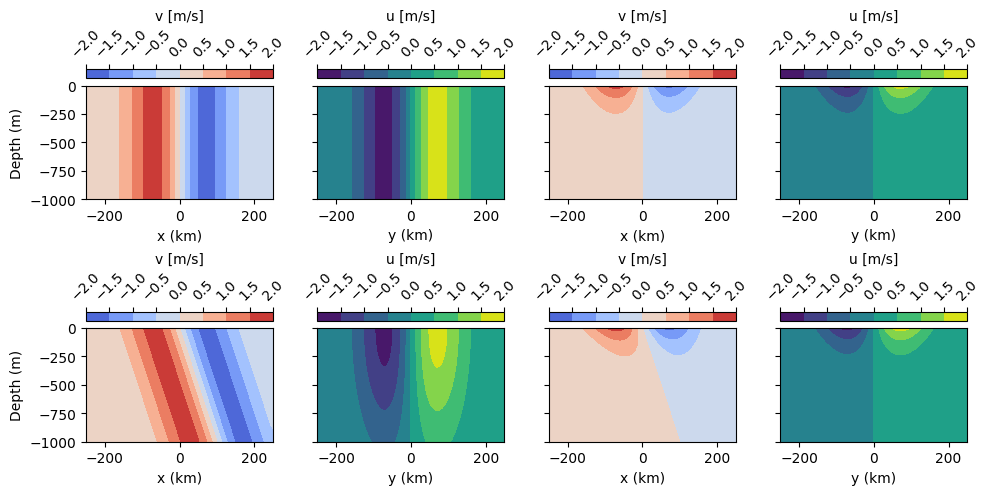

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)
x = modelled_data['x']/1000
y = modelled_data['y']/1000
for i, ax_pair in enumerate(axs.reshape(-1, 2)):
    eddy = eddies[i]
    U = modelled_data[eddy]['U'][modelled_data[eddy]['U'].shape[0] // 2, :, :]
    V = modelled_data[eddy]['V'][:, modelled_data[eddy]['V'].shape[1] // 2, :]
    im1 = ax_pair[0].contourf(x, z, V.T, cmap='coolwarm')
    im2 = ax_pair[1].contourf(y, z, U.T)

    df = plot_data[eddy]['df']
    ax_pair[0].plot(df['xc']/1000, df['Depth'], color='k', linestyle='--')
    ax_pair[1].plot(df['yc']/1000, df['Depth'], color='k', linestyle='--')

    ax_pair[0].set_xlabel('x (km)')
    ax_pair[1].set_xlabel('y (km)')

    cbar1 = fig.colorbar(im1, ax=ax_pair[0], orientation='horizontal', location='top', label='v [m/s]')
    cbar2 = fig.colorbar(im2, ax=ax_pair[1], orientation='horizontal', location='top', label='u [m/s]')

    # Rotate colorbar ticks
    cbar1.ax.tick_params(axis='x', rotation=45)
    cbar2.ax.tick_params(axis='x', rotation=45)

axs[0, 0].set_ylabel('Depth (m)')
axs[1, 0].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()

In [8]:
plot_data[eddy].keys()

dict_keys(['df', 'lnam0', 'ow0', 'lnam1', 'ow1'])

IndexError: single positional indexer is out-of-bounds

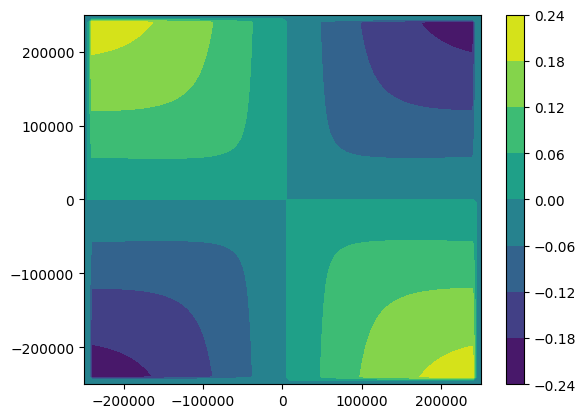

In [10]:
eddy = 'Eddy2'

depth_lvl = 1

lnam = plot_data[eddy]['lnam'+str(depth_lvl)]

df = plot_data[eddy]['df']

x = modelled_data['x']
y = modelled_data['y']
plt.contourf(x, y, lnam.T)
plt.colorbar()

plt.scatter(df.iloc[depth_lvl]['xc'], df.iloc[depth_lvl]['yc'])


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

eddy = 'Eddy2'
depth_lvl = 20

lnam = plot_data[eddy]['lnam' + str(depth_lvl)]
df = plot_data[eddy]['df']

x = modelled_data['x']
y = modelled_data['y']
X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
# ax.plot_surface(X, Y, lnam.T, cmap='viridis', edgecolor='none')

# Add scatter points for the eddy centre
ax.scatter(df.iloc[depth_lvl]['xc'], df.iloc[depth_lvl]['yc'], np.nanmax(lnam), c='r', s=100)

# Add labels and color bar
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Value')
plt.colorbar(ax.plot_surface(X, Y, lnam.T, cmap='viridis', edgecolor='none'), ax=ax, shrink=0.5)

plt.show()


In [ ]:
df

In [ ]:
eddy = 'Eddy3'

err1 = np.nanmean(np.abs(plot_data[eddy]['lnam14']- plot_data[eddy]['lnam15']))
err2 = np.nanmean(np.abs(plot_data[eddy]['lnam5']- plot_data[eddy]['lnam6']))

err = np.abs(err1-err2)
err

In [ ]:
np